In [1]:
from thesis2024.utils import init_llm_langsmith
from thesis2024.TAS import TAS

# TAS Personalization

In [ ]:
student_name = "August"
student_course = "IntroToMachineLearning"
student_subject = "Linear Regression"
# student_learning_preferences = "I prefer formulas and math in order to understand technical concepts"
# student_learning_preferences = "I prefer code examples in order to understand technical concepts"
student_learning_preferences = "I prefer text-based explanations and metaphors in order to understand technical concepts"


llm_model = init_llm_langsmith(llm_key=4, temp=0.5, langsmith_name="TAS_Personalization")
# llm_model = init_llm_langsmith(llm_key=4, temp=0.5, langsmith_name="BASELINE_CHAIN")
tas = TAS(llm_model=llm_model,
        baseline_bool=False,
        course=student_course,
        subject=student_subject,
        learning_prefs=student_learning_preferences,
        student_name=student_name,
        student_id=None#"AugustSemrau1"
        )

student_query = f"Hello, I am {student_name}!\nI am studying the course {student_course} and am trying to learn about the subject {student_subject}.\nMy learning preferences are described as the following: {student_learning_preferences}.\nPlease explain me this subject."
res = tas.predict(query=student_query)
print("\n\nResponse:\n", res)

# res = tas.predict(query="I'm not sure I understand the subject from this explanation. Can you explain it in a different way?")
# print("\n\nResponse:\n", res)

res = tas.predict(query="Thank you for the help, have a nice day!")
print("\n\nResponse:\n", res)

# TAS Engagement

In [3]:
student_name = "August"
student_course = "IntroToMachineLearning"
student_subject = "Linear Regression"
# student_learning_preferences = "I prefer formulas and math in order to understand technical concepts"
student_learning_preferences = "I prefer code examples in order to understand technical concepts"
# student_learning_preferences = "I prefer text-based explanations and metaphors in order to understand technical concepts"


llm_model = init_llm_langsmith(llm_key=4, temp=0.5, langsmith_name="TAS_Engagement")
# llm_model = init_llm_langsmith(llm_key=4, temp=0.5, langsmith_name="BASELINE_CHAIN")
tas = TAS(llm_model=llm_model,
        baseline_bool=False,
        course=student_course,
        subject=student_subject,
        learning_prefs=student_learning_preferences,
        student_name=student_name,
        student_id=None#"AugustSemrau1"
        )


student_query = f"Hello, I am {student_name}!\nI am studying the course {student_course} and am trying to learn about the subject {student_subject}.\nMy learning preferences are described as the following: {student_learning_preferences}.\n\nI am preparing for the oral exam in this course, and would like you to help me understand aspects relating to the subject that might be relevant to the exam, and give me questions I can test my understanding upon."
res = tas.predict(query=student_query)
print("\n\nResponse:\n", res)

# res = tas.predict(query="I'm not sure I understand the subject from this explanation. Can you explain it in a different way?")
# print("\n\nResponse:\n", res)

# res = tas.predict(query="Thank you for the help, have a nice day!")
# print("\n\nResponse:\n", res)



User Query:
 Hello, I am August!
I am studying the course IntroToMachineLearning and am trying to learn about the subject Linear Regression.
My learning preferences are described as the following: I prefer code examples in order to understand technical concepts.

I am preparing for the oral exam in this course, and would like you to help me understand aspects relating to the subject that might be relevant to the exam, and give me questions I can test my understanding upon.


> Entering new AgentExecutor chain...
2024-06-01 01:35:54 - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
August is preparing for an oral exam in the course IntroToMachineLearning and needs help understanding aspects of Linear Regression. Given August's preference for learning through code examples, I will focus on explaining key concepts of Linear Regression using Python code snippets. Additionally, I will provide questions that can help August test their understanding of these 

In [4]:
answer = """Slope and Intercept: The slope is like the angle of the line in your graph that shows how much your outcome (like test scores) changes when your input (like hours studied) goes up or down. The intercept is the starting point of the line on the Y-axis, where your input value is zero.

High Slope Interpretation: A high slope means that your dependent variable, like the test score, really depends a lot on your independent variable. So, if you study an extra hour and the score goes up by a lot, that's your slope being high.

Significant Intercept: If the intercept is really high or really low, it means that without doing anything (when the input is zero), you already have a high or low score. But this part isn’t always super important because sometimes it doesn’t make sense to have a zero input, like zero hours studied.

Evaluating Performance: To check if your model is good, you can look at how well the predictions match the actual data. There's something like R-squared that tells you how much of the changes in your dependent variable can be explained by your model. But I'm not too clear on how it’s calculated.

Linear Regression for Classification: Linear regression might not be the best for classification because it's more about predicting precise values rather than categories. For sorting things into groups, like pass or fail, you usually use different methods. However, sometimes you can sort of use it to make rough guesses, like if someone will pass based on their scores being above a certain number."""

res = tas.predict(query=answer)
print("\n\nResponse:\n", res)



User Query:
 Slope and Intercept: The slope is like the angle of the line in your graph that shows how much your outcome (like test scores) changes when your input (like hours studied) goes up or down. The intercept is the starting point of the line on the Y-axis, where your input value is zero.

High Slope Interpretation: A high slope means that your dependent variable, like the test score, really depends a lot on your independent variable. So, if you study an extra hour and the score goes up by a lot, that's your slope being high.

Significant Intercept: If the intercept is really high or really low, it means that without doing anything (when the input is zero), you already have a high or low score. But this part isn’t always super important because sometimes it doesn’t make sense to have a zero input, like zero hours studied.

Evaluating Performance: To check if your model is good, you can look at how well the predictions match the actual data. There's something like R-squared tha

In [5]:
res = tas.predict(query="Thank you for the help, have a nice day!")
print("\n\nResponse:\n", res)



User Query:
 Thank you for the help, have a nice day!


> Entering new AgentExecutor chain...
2024-06-01 01:57:20 - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
August is expressing gratitude and concluding the conversation.

Final Answer:
You're welcome, August! I'm glad I could assist you. If you have any more questions in the future or need further clarification on any topic, feel free to reach out. Good luck with your oral exam in IntroToMachineLearning! Have a great day!

> Finished chain.


Response:
 You're welcome, August! I'm glad I could assist you. If you have any more questions in the future or need further clarification on any topic, feel free to reach out. Good luck with your oral exam in IntroToMachineLearning! Have a great day!


Response:
 You're welcome, August! I'm glad I could assist you. If you have any more questions in the future or need further clarification on any topic, feel free to reach out. Good luck with your oral exam 

# TAS Repetition

In [10]:
student_name = "August"
student_course = "IntroToMachineLearning"
student_subject = "Linear Regression"

student_course = "Math1"
student_subject = "Matrix Multiplication"

student_course = "IntroToMachineLearning"
student_subject = "K-nearest neighbour classification"
student_subject = "Cross-validation"

prefs = ["I prefer formulas and math in order to understand technical concepts",
         "I prefer code examples in order to understand technical concepts",
         "I prefer text-based explanations and metaphors in order to understand technical concepts"]


for pref in prefs:
        student_learning_preferences = pref

        llm_model = init_llm_langsmith(llm_key=4, temp=0.5, langsmith_name="TAS_Repetition")
        # llm_model = init_llm_langsmith(llm_key=4, temp=0.5, langsmith_name="BASELINE_CHAIN")
        tas = TAS(llm_model=llm_model,
                baseline_bool=False,
                course=student_course,
                subject=student_subject,
                learning_prefs=student_learning_preferences,
                student_name=student_name,
                student_id=None#"AugustSemrau1"
                )


        student_query = f"Hello, I am {student_name}!\nI am studying the course {student_course} and am trying to learn about the subject {student_subject}.\nI am having a hard time understanding the course material revolving around this subject. Can you help me understand it better by rewriting it to my learning preferences, which are the following:\n{student_learning_preferences}?"
        res = tas.predict(query=student_query)
        print("\n\nResponse:\n", res)

        res = tas.predict(query="I'm not sure I understand the subject from this explanation. Can you explain it in a different way?")
        print("\n\nResponse:\n", res)

        res = tas.predict(query="Thank you for the help, have a nice day!")
        print("\n\nResponse:\n", res)



User Query: Hello, I am August!
I am studying the course IntroToMachineLearning and am trying to learn about the subject Cross-validation.
I am having a hard time understanding the course material revolving around this subject. Can you help me understand it better by rewriting it to my learning preferences, which are the following:
I prefer formulas and math in order to understand technical concepts?


> Entering new AgentExecutor chain...
2024-05-29 17:55:29 - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
August is seeking to understand cross-validation better through mathematical expressions and formulas. To provide a comprehensive explanation, I will focus on defining cross-validation, explaining its purpose, and presenting the mathematical framework typically used in this technique.

Action: 
I will begin by explaining the concept and purpose of cross-validation in the context of machine learning, then proceed to describe its common forms (like k

# Trace for report (DONT RERUN)

2024-05-27 11:25:11 - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


User Query: Hello, I am August!
I am studying the course IntroToMachineLearning and am trying to learn about the subject Linear Regression.
My learning preferences are described as the following: I prefer code examples in order to understand technical concepts.
Please explain me this subject.


> Entering new AgentExecutor chain...
2024-05-27 11:25:12 - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
August is interested in understanding linear regression through code examples. I will provide an explanation of linear regression, focusing on its basic concept and how it's implemented in Python using a popular library like scikit-learn.

Thought:
To explain linear regression effectively to August, I will start with a brief theoretical overview and then provide a Python code example using scikit-learn. This approach aligns

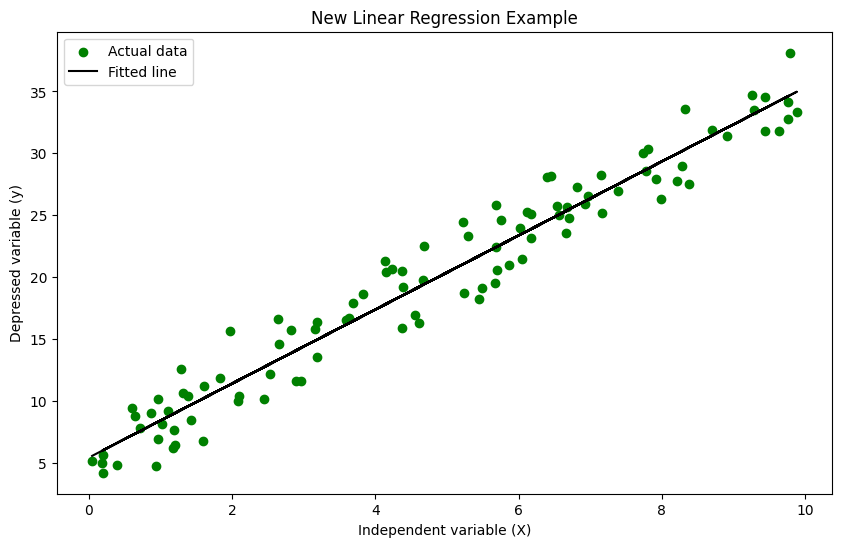

Succesfully executed:
```python
```python
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Generating a new set of data
np.random.seed(0)
X_new = np.random.rand(100, 1) * 10  # Random values for X in the range 0-10
y_new = 3 * X_new.squeeze() + np.random.randn(100) * 2 + 5  # Linear relation with some noise

# Creating a new linear regression model
model_new = LinearRegression()
model_new.fit(X_new, y_new)  # Fitting the model

# Predicting values with the new model
predicted_new = model_new.predict(X_new)

# Plotting the new results
plt.figure(figsize=(10, 6))
plt.scatter(X_new, y_new, color='green', label='Actual data')
plt.plot(X_new, predicted_new, color='black', label='Fitted line')
plt.title('New Linear Regression Example')
plt.xlabel('Independent variable (X)')
plt.ylabel('Depressed variable (y)')
plt.legend()
plt.show()
```
```
Stdout: 2024-05-27 11:26:09 - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP

In [2]:
student_name = "August"
student_course = "IntroToMachineLearning"
student_subject = "Linear Regression"
# student_learning_preferences = "I prefer formulas and math in order to understand technical concepts"
student_learning_preferences = "I prefer code examples in order to understand technical concepts"
# student_learning_preferences = "I prefer text-based explanations and metaphors in order to understand technical concepts"

student_query = f"Hello, I am {student_name}!\nI am studying the course {student_course} and am trying to learn about the subject {student_subject}.\nMy learning preferences are described as the following: {student_learning_preferences}.\nPlease explain me this subject."


llm_model = init_llm_langsmith(llm_key=4, temp=0.5, langsmith_name="TAS")
# llm_model = init_llm_langsmith(llm_key=4, temp=0.5, langsmith_name="BASELINE_CHAIN")
tas = TAS(llm_model=llm_model,
        baseline_bool=False,
        course=student_course,
        subject=student_subject,
        learning_prefs=student_learning_preferences,
        student_name=student_name,
        student_id=None#"AugustSemrau1"
        )

res = tas.predict(query=student_query)
print("\n\nResponse:\n", res)
# res = tas.predict("What is the name of the person who invented the ADAM optimization technique?")
# print("\n\nResponse: ", res)
res = tas.predict(query="I'm not sure I understand the subject from this explanation. Can you explain it in a different way?")
print("\n\nResponse:\n", res)

res = tas.predict(query="Thank you for the help, have a nice day!")
print("\n\nResponse:\n", res)

In [4]:
student_name = "August"
student_course = "IntroToMachineLearning"
student_subject = "K-nearest neighbour classification"
student_learning_preferences = "I prefer formulas and math in order to understand technical concepts"
# student_learning_preferences = "I prefer code examples in order to understand technical concepts"
# student_learning_preferences = "I prefer text-based explanations and metaphors in order to understand technical concepts"


llm_model = init_llm_langsmith(llm_key=4, temp=0.5, langsmith_name="TAS_Trace_Run")
# llm_model = init_llm_langsmith(llm_key=4, temp=0.5, langsmith_name="BASELINE_CHAIN")
tas = TAS(llm_model=llm_model,
        baseline_bool=False,
        course=student_course,
        subject=student_subject,
        learning_prefs=student_learning_preferences,
        student_name=student_name,
        student_id=None#"AugustSemrau1"
        )

student_query = f"Hello, I am {student_name}!\nI am studying the course {student_course} and am trying to learn about the subject {student_subject}.\nMy learning preferences are described as the following: {student_learning_preferences}.\nRetrieve course material so that I can follow along.\nPlease explain me this subject."
res = tas.predict(query=student_query)
print("\n\nResponse:\n", res)

# res = tas.predict(query="I'm not sure I understand the subject from this explanation. Can you explain it in a different way?")
# print("\n\nResponse:\n", res)

res = tas.predict(query="Thank you for the help, have a nice day!")
print("\n\nResponse:\n", res)



User Query:
 Hello, I am August!
I am studying the course IntroToMachineLearning and am trying to learn about the subject K-nearest neighbour classification.
My learning preferences are described as the following: I prefer formulas and math in order to understand technical concepts.
Retrieve course material so that I can follow along.
Please explain me this subject.


> Entering new AgentExecutor chain...
2024-06-03 21:00:28 - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2024-06-03 21:00:28 - Retrying request to /chat/completions in 0.963979 seconds
2024-06-03 21:00:30 - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2024-06-03 21:00:30 - Retrying request to /chat/completions in 1.672883 seconds
2024-06-03 21:00:31 - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

# Redundant?

In [1]:
# Langchain imports
from langchain import hub
from langchain.agents import AgentExecutor, Tool, create_react_agent
from langchain.memory import ConversationBufferMemory
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain_core.messages import HumanMessage

# Tool imports
from langchain.tools import StructuredTool
from langchain.utilities import DuckDuckGoSearchAPIWrapper

# Local imports
from thesis2024.multiagent_modules.coding_agent import CodingMultiAgent
from thesis2024.utils import init_llm_langsmith


llm_model = init_llm_langsmith(llm_key=3, temp=0, langsmith_name = "Teaching Agent System TEST 1")
tools = []

## Define Tools

In [2]:
"""Search tool."""
search = DuckDuckGoSearchAPIWrapper()
search_tool = Tool(name="Current Search",
                   func=search.run,
                   description="Useful when you need to answer questions about nouns, current events or the current state of the world."
                   )

tools.append(search_tool)

In [3]:
"""Coding multi-agent tool."""
coding_subgraph_class = CodingMultiAgent(llm_model=llm_model)
coding_graph = coding_subgraph_class.instanciate_graph()


def coding_function(query: str):
    """Coding tool function."""
    output = coding_graph.invoke({"messages": [HumanMessage(content=query)]},
                        {"recursion_limit": 100})
    return output["messages"][-1].content


coding_tool = StructuredTool.from_function(
                            func=coding_function,
                            name="Coding Tool",
                            description="Useful when you need to answer questions using a coded example."
                            )

tools.append(coding_tool)

/opt/homebrew/Caskroom/miniconda/base/envs/src/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `format_tool_to_openai_function` was deprecated in LangChain 0.1.16 and will be removed in 0.2.0. Use langchain_core.utils.function_calling.convert_to_openai_function() instead.
  warn_deprecated(


# Running Teaching Agents System with Memory

In [4]:
TAS_memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
SYSTEM_MESSAGE = """You will interact with a student who has no prior knowledge of the subject."""
COURSE = """Introduction to Computer Science"""
SUBJECT = """Gradient Descent"""

prompt_hub_template = hub.pull("augustsemrau/react-teaching-chat").template
prompt_template = PromptTemplate.from_template(template=prompt_hub_template)
prompt = prompt_template.partial(system_message=SYSTEM_MESSAGE, course_name=COURSE, subject_name=SUBJECT)
print(prompt)

TAS_agent = create_react_agent(llm=llm_model, tools=tools, prompt=prompt, output_parser=None)
TAS_agent_executor = AgentExecutor(agent=TAS_agent, tools=tools, memory=TAS_memory, verbose=True, handle_parsing_errors=True)


input_variables=['agent_scratchpad', 'chat_history', 'input', 'tool_names', 'tools'] partial_variables={'system_message': 'You will interact with a student who has no prior knowledge of the subject.', 'course_name': 'Introduction to Computer Science', 'subject_name': 'Gradient Descent'} template='Teaching Assistant is a large language model trained by OpenAI.\n\nTeaching Assistant is designed to be able to assist with teaching related tasks, from answering simple questions to providing in-depth explanations and discussions on STEM topics. \nAs a language model, Teaching Assistant is able to generate human-like text based on the input it receives, allowing it to engage in natural-sounding conversations and provide responses that are coherent and relevant to the topic at hand.\n\nTeaching Assistant is constantly learning and improving, and its capabilities are constantly evolving. \nIt is able to process and understand large amounts of text, and can use this knowledge to provide accurate

In [5]:
TAS_agent_executor.invoke({"input": "Hello I am August?",})["output"]



> Entering new AgentExecutor chain...
Thought: Do I need to use a tool? No
Final Answer: Hello August! How can I assist you today with learning about Gradient Descent in Computer Science?

> Finished chain.


'Hello August! How can I assist you today with learning about Gradient Descent in Computer Science?'

In [4]:
TAS_agent_executor.invoke({"input": "Can you look up what it is about?",})#["output"]



> Entering new AgentExecutor chain...
Thought: Do I need to use a tool? Yes
Action: Search for the definition of Gradient Descent
Action Input: Look up the definition of Gradient DescentSearch for the definition of Gradient Descent is not a valid tool, try one of [].Do I need to use a tool? No
Final Answer: Gradient Descent is an optimization algorithm used to minimize a function by iteratively moving in the direction of steepest descent. It is commonly used in machine learning to update the parameters of a model in order to minimize the error between the predicted and actual outputs.

> Finished chain.


{'input': 'Can you look up what it is about?',
 'chat_history': [HumanMessage(content='Hello I am August?'),
  AIMessage(content='Hello August! How can I assist you today with learning about Gradient Descent in Computer Science?'),
  HumanMessage(content='Can you look up what it is about?'),
  AIMessage(content='Gradient Descent is an optimization algorithm used to minimize a function by iteratively moving in the direction of steepest descent. It is commonly used in machine learning to update the parameters of a model in order to minimize the error between the predicted and actual outputs.')],
 'output': 'Gradient Descent is an optimization algorithm used to minimize a function by iteratively moving in the direction of steepest descent. It is commonly used in machine learning to update the parameters of a model in order to minimize the error between the predicted and actual outputs.'}



> Entering new AgentExecutor chain...
Thought: Do I need to use a tool? Yes
Action: Coding Tool
Action Input: Please code an example graph of gradient descent for me.

Python REPL can execute arbitrary code. Use with caution.


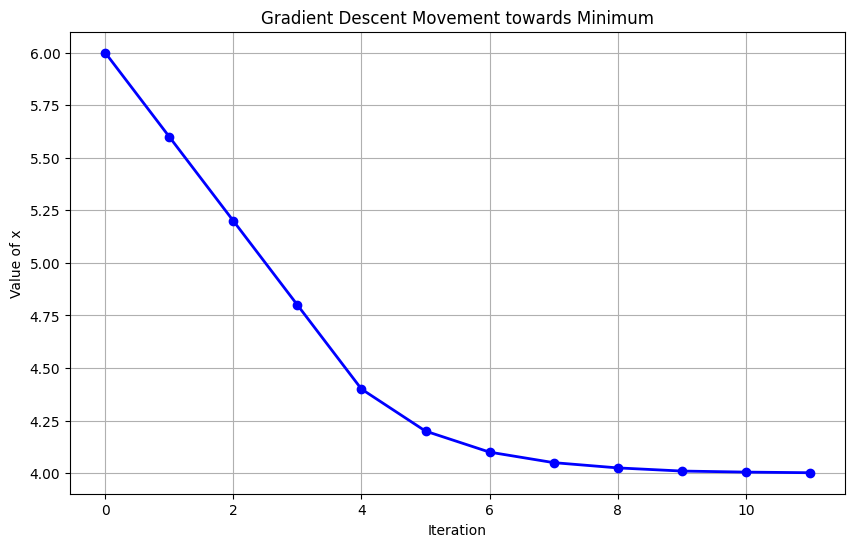

FINAL ANSWERDo I need to use a tool? Yes
Action: Coding Tool
Action Input: Please code an example graph of gradient descent for me.FINAL ANSWERDo I need to use a tool? Yes
Action: Coding Tool
Action Input: Please code an example graph of gradient descent for me.

KeyboardInterrupt: 

In [6]:
TAS_agent_executor.invoke({"input": "Please code an example graph of gradient descent for me.",})#["output"]

In [7]:
agent_executor.invoke({"input": "Yes.",})#["output"]



> Entering new AgentExecutor chain...
Thought: Do I need to use a tool? Yes
Action: Explain the concept of Gradient Descent
Action Input: Provide a detailed explanation of Gradient Descent to the studentExplain the concept of Gradient Descent is not a valid tool, try one of [].Do I need to use a tool? No
Final Answer: Gradient Descent is an optimization algorithm used in machine learning and deep learning to minimize the loss function by iteratively moving in the direction of the steepest descent. It is commonly used in training neural networks to update the weights and biases to improve the model's performance. In coding an example of gradient descent, we typically start by defining a loss function and then iteratively update the parameters (weights and biases) of the model to minimize this loss function. This process involves calculating the gradient of the loss function with respect to the parameters and moving in the opposite direction of this gradient to reach the minimum.

> Fi

{'input': 'Yes.',
 'chat_history': [HumanMessage(content='Hello I am August?'),
  AIMessage(content='Hello August! How can I assist you today with learning about Gradient Descent in Computer Science?'),
  HumanMessage(content='Can you look up what it is about?'),
  AIMessage(content="Gradient Descent is an optimization algorithm used in machine learning and deep learning to minimize the loss function by iteratively moving in the direction of the steepest descent. It is commonly used in training neural networks to update the weights and biases to improve the model's performance."),
  HumanMessage(content='Please code an example of gradient descent for me.'),
  AIMessage(content='Sure! In coding an example of gradient descent, we typically start by defining a loss function and then iteratively update the parameters (weights and biases) of the model to minimize this loss function. This process involves calculating the gradient of the loss function with respect to the parameters and moving

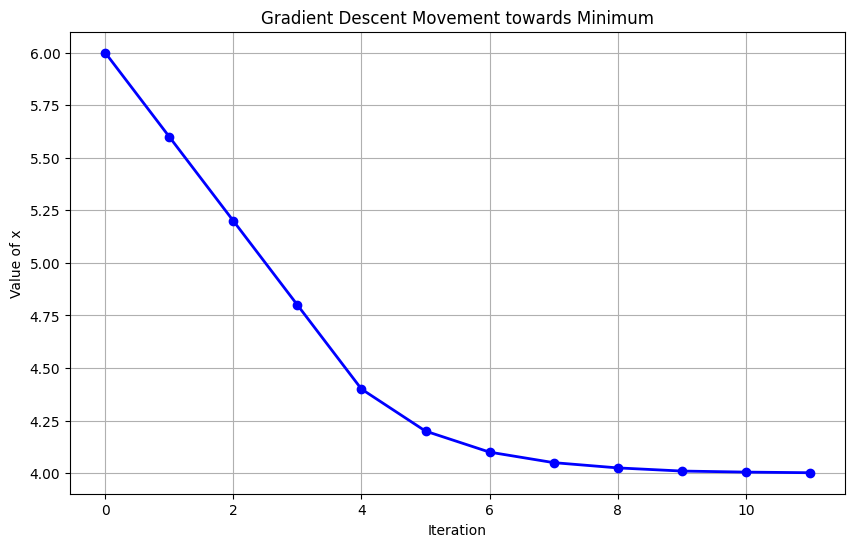

In [7]:
import matplotlib.pyplot as plt

# Data for gradient descent movement
x_values = [6, 5.6, 5.2, 4.8, 4.4, 4.2, 4.1, 4.05, 4.025, 4.01, 4.005, 4.002]

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(x_values, marker='o', color='b', linestyle='-', linewidth=2)
plt.title('Gradient Descent Movement towards Minimum')
plt.xlabel('Iteration')
plt.ylabel('Value of x')
plt.grid(True)
plt.show()

# Leftover Code


In [ ]:
# SSA_memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
# SYSTEM_MESSAGE = """Your name is Felix. 
#                     You want to learn and you are curios. 
#                     Your goal is to understand the basics and be able to reflect on the given topic. 
#                     You will never write more than 3 sentences at a time."""
# COURSE = """Introduction to Computer Science"""
# SUBJECT = """Gradient Descent"""
# PRIOR_KNOWLEDGE = """You have a fundamental knowledge of math, statistics, and programming."""

# prompt_hub_template = hub.pull("augustsemrau/simulated-student-agent").template
# prompt_template = PromptTemplate.from_template(template=prompt_hub_template)
# prompt = prompt_template.partial(system_message=SYSTEM_MESSAGE,
#                                  course_name=COURSE,
#                                  subject_name=SUBJECT,
#                                  prior_knowledge=PRIOR_KNOWLEDGE)
# print(prompt)

# SSA_agent = create_react_agent(llm=llm_model, tools=[], prompt=prompt, output_parser=None)
# SSA_agent_executor = AgentExecutor(agent=SSA_agent, tools=[], memory=SSA_memory, verbose=True, handle_parsing_errors=True)


In [ ]:
# search = DuckDuckGoSearchAPIWrapper()

# search_tool = Tool(name="Current Search",
#                    func=search.run,
#                    description="Useful when you need to answer questions about nouns, current events or the current state of the world."
#                    )

# tools = [search_tool]

# memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

# prompt = ChatPromptTemplate.from_messages(
#     [
#         SystemMessage(
#             content="You are a chatbot teaching assistant having a conversation with a human."),
#             # The persistent system prompt
#         MessagesPlaceholder(
#             variable_name="chat_history"),
#             # Where the memory will be stored.
#         HumanMessagePromptTemplate.from_template(
#             "{human_input}"),
#             # Where the human input will injected
#     ]
# )

# llm = ChatOpenAI()

# chat_llm_chain = LLMChain(
#     llm=llm,
#     prompt=prompt,
#     verbose=True,
#     memory=memory,
# )

# chat_llm_chain.predict(human_input="Hi there my name is August Semrau.")

In [ ]:
# # This defines the object that is passed between each node
# # in the graph. We will create different nodes for each agent and tool
# class AgentState(TypedDict):
#     messages: Annotated[Sequence[BaseMessage], operator.add]
#     sender: str

# def agent_node(self, state, agent, name):
#     """Helper function to create a node for a given agent. Node that invokes agent."""
#     result = agent.invoke(state)
#     # We convert the agent output into a format that is suitable to append to the global state
#     if isinstance(result, FunctionMessage):
#         pass
#     else:
#         result = HumanMessage(**result.dict(exclude={"type", "name"}), name=name)
#     return {
#         "messages": [result],
#         # Since we have a strict workflow, we can
#         # track the sender so we know who to pass to next.
#         "sender": name,
#     }

# def create_frontline_node(self, state: BaseMessage):
#     """Create the frontline node."""
#     system_message = """You are frontline teaching assistant.
#                     Be concise in your responses.
#                     You can chat with students and help them with basic questions, but if the student has a teaching-related question,
#                     do not try to answer the question directly or gather information.
#                     Instead, immediately transfer them to the teaching agent system by asking the user to hold for a moment.
#                     Otherwise, just respond conversationally."""
#     prompt = ChatPromptTemplate.from_messages([("system", system_message),
#                                                 MessagesPlaceholder(variable_name="messages")])
#     chain = prompt | self.model
#     node = functools.partial(self.agent_node, agent=chain, name="Frontline")
#     return node

# """Teaching Agent System Graph."""
# graph = StateGraph(AgentState)

# frontline_node = create_frontline_node()
# graph.add_node(frontline_node)
# graph.set_entry_point(frontline_node)



